# Import Modules

In [1]:
import fiona 
import geopandas as gpd
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

import os

import matplotlib.pyplot as plt
import seaborn as sns

import tqdm
import time

from collections import defaultdict, Counter

# Define classes for node and graph

In [2]:
class Node:
    
    def __init__(self, coor):
        self.coor = coor # (long, lat)
        self.sons = set() # downstream
        self.father = set() # upstream

In [3]:
class waste_water_processor:
    
    def __init__(self, base_dir):
        
        self.base = base_dir #where to read saved files
        if not self.base.endswith('/'):
            self.base += '/'
        self.init() #empty data structures
        
    def init(self):
        self.coor_to_name = defaultdict(list)
        self.all_nodes = {}
        self.name_to_coor = {}
        self.build_graph()
    
    def build_graph(self):
        #load saved files to build the whole graph
        data = pd.read_csv(self.base + 'connections.csv', dtype={'cbg':str, 'cb':str})
        data['name'] = data['name'].apply(eval)
        data['down_stream'] = data['down_stream'].apply(eval)
        data['up_stream'] = data['up_stream'].apply(eval)
        
        #initialize basic nodes
        print("Initializing Manholes")
        for row in tqdm.tqdm(range(data.shape[0])):
            long = data.loc[row, 'long']
            lat = data.loc[row, 'lat']
            names = data.loc[row, 'name']
            cbg = data.loc[row, 'cbg']
            cb = data.loc[row, 'cb']
            coor = (long, lat)
            self.all_nodes[coor] = Node(coor)
            self.coor_to_name[coor] = names
            for name in names:
                self.name_to_coor[name] = coor
            self.all_nodes[coor].cb = cb
            self.all_nodes[coor].cbg = cbg
                
        #connect upstreams and downstreams
        print("Connecting Manholes")
        for row in tqdm.tqdm(range(data.shape[0])):
            long = data.loc[row, 'long']
            lat = data.loc[row, 'lat']
            coor = (long, lat)
            
            downstream = data.loc[row, 'down_stream']
            for next_coor in downstream:
                next_coor = self.locate_coor(next_coor)
                self.all_nodes[coor].sons |= set([next_coor])
                
            upstream = data.loc[row, 'up_stream']
            for prev_coor in upstream:
                prev_coor = self.locate_coor(prev_coor)
                self.all_nodes[coor].father |= set([prev_coor])
                
        #check how many manholes are there in each census block
        self.cb_counter = defaultdict(int)
        for coor, node in self.all_nodes.items():
            self.cb_counter[node.cb] += 1
            
        population = pd.read_csv(self.base + 'us2019_yolo.csv', dtype={'block_fips':str})
        self.all_cb = population.block_fips.values.tolist()
        self.all_cb.sort()
        
        #load sampling locations
        self.locations = pd.read_csv(self.base + 'COD sampling MHs.csv')
            
    def locate_coor(self, coor):
        '''
        This functions reads a coordinate (format long, lat) and find the closest manhole
        '''
        if self.all_nodes.get(coor, None) is None: # not a real node
            smallest = 10000
            for coor0 in self.all_nodes.keys():
                dist = (coor0[0] - coor[0])**2 + (coor0[1] - coor[1])**2
                if dist < smallest:
                    smallest = dist
                    target_coor = coor0
            coor = target_coor
            return coor
        else:
            return coor
    
    def dfs(self, coor, visited, direction):
        '''
        This is a inside utility function. Do not use.
        DFS starts from a manhole and look for its upstreams/downstreams, depending on the value of direction
        '''
        if not visited[coor]:
            visited[coor] = 1
            if direction == 'upstream':
                next_list = self.all_nodes[coor].father
            else:
                next_list = self.all_nodes[coor].sons
            for next_coor in next_list:
                self.dfs(next_coor, visited, direction)
                
    def find_connection(self, coor, direction):
        '''
        Given a coordinate (long, lat), find its nearest manhole and search for its all upstreams/downstreams
        '''
        direction = direction.lower()
        assert direction in ['downstream', 'upstream']
        
        coor = self.locate_coor(coor)
        visited = defaultdict(int)
        self.dfs(coor, visited, direction)
        origin = coor
        
        all_x = []
        all_y = []
        for new_coor in visited.keys():
            if visited[new_coor]:
                all_x.append(new_coor[0])
                all_y.append(new_coor[1])
                
        return all_x, all_y
    
    def plot_connection(self, coor, direction):
        '''
        Given a coordinate (long, lat), find its nearest manhole and plot its all upstreams/downstreams
        '''
    
        direction = direction.lower()
        assert direction in ['downstream', 'upstream']
        
        plt.figure(figsize=(17, 8))
        
        all_x = []
        all_y = []
        for key, value in self.coor_to_name.items():
            all_x.append(key[0])
            all_y.append(key[1])
        
        plt.scatter(all_x, all_y, label='normal')
        
        coor = self.locate_coor(coor)
        all_x, all_y = self.find_connection(coor, direction)
        
        plt.scatter(all_x, all_y, label=direction)
        
        plt.scatter(coor[0], coor[1], label='source', color='red', marker='s')
        
        plt.legend()
        plt.title("{} nodes for node {}".format(direction, list(self.coor_to_name[coor])[0]))
        plt.show()
        
    def get_population_composition(self, node_name):
        '''
        Inside utility function, do not use.
        Get the population composition at a give manhole
        '''
        node_name += '-1'
        node = self.all_nodes[self.name_to_coor[node_name]]
        return node.population
        
    def find_collection_points(self, source_locations):
        '''
        For a given DataFrame of Infection locations, find the expectation of infection at each collection point
        
        Params:
        source_locations : pd.DataFrame, should have at least two columns.
            columns 'census_block', shows which census blocks have infections
            columns 'positive', shows positive counts for each corresponding census block
        '''
        #check initial values
        infection = defaultdict(lambda : 0)
        for cb, count in zip(source_locations.census_block, source_locations.positive):
            infection[cb] = count
        
        #topological sort
        in_order = defaultdict(int)
        for coor, node in self.all_nodes.items():
            cb = node.cb
            node.population = defaultdict(float)
            node.population[cb] = infection[cb] / self.cb_counter[cb]
            for next_coor in node.sons:
                in_order[next_coor] += 1
        
        queue = []
        for coor, node in self.all_nodes.items():
            if in_order[coor] == 0:
                queue.append(coor)
                
        while queue:
            next_queue = []
            for coor in queue:
                node = self.all_nodes[coor]
                N = len(node.sons)
                for next_coor in node.sons:
                    next_node = self.all_nodes[next_coor]
                    for key, value in node.population.items():
                        next_node.population[key] += value / len(node.sons)
                    in_order[next_coor] -= 1
                    if in_order[next_coor] == 0:
                        next_queue.append(next_coor)
            queue = next_queue
        
        infection = [infection[cb] for cb in self.all_cb]
        MH_to_cb = {'census_block':self.all_cb, 'total_infection':infection}
        for row in range(self.locations.shape[0]):
            MH = self.locations.loc[row, 'MH ID']
            composition = self.get_population_composition(MH)
            temp_values = []
            for cb in self.all_cb:
                temp_values.append(composition[cb])
            MH_to_cb[MH] = temp_values
            
        return pd.DataFrame(MH_to_cb)

# Initialize Graph from existing Files

In [4]:
graph = waste_water_processor('./')

  0%|          | 0/3227 [00:00<?, ?it/s]

Initializing Manholes
Connecting Manholes


100%|██████████| 3227/3227 [00:16<00:00, 190.52it/s]


# Example of plotting Upstream/Downstream

Use `graph.plot_connection` method, pass in a coordinate and the direction

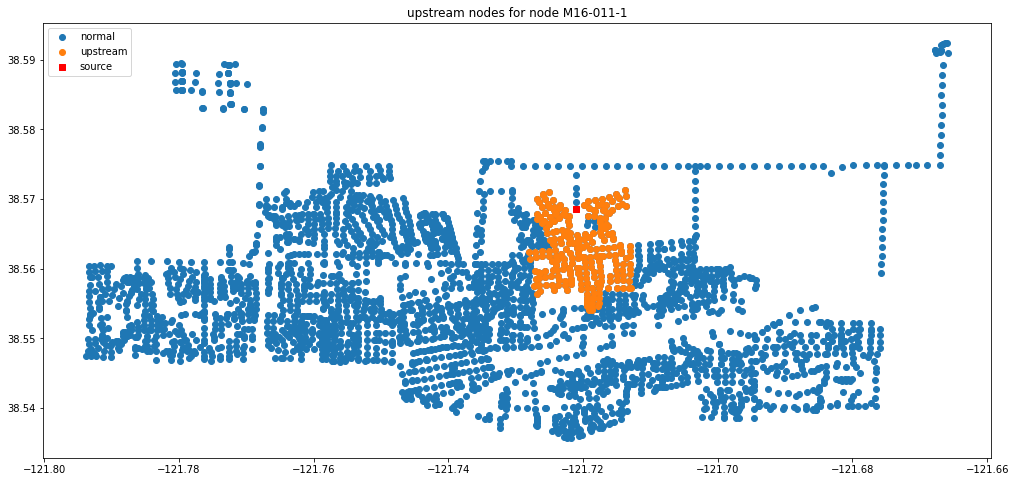

In [5]:
graph.plot_connection(graph.name_to_coor['M16-011-1'], 'upstream')

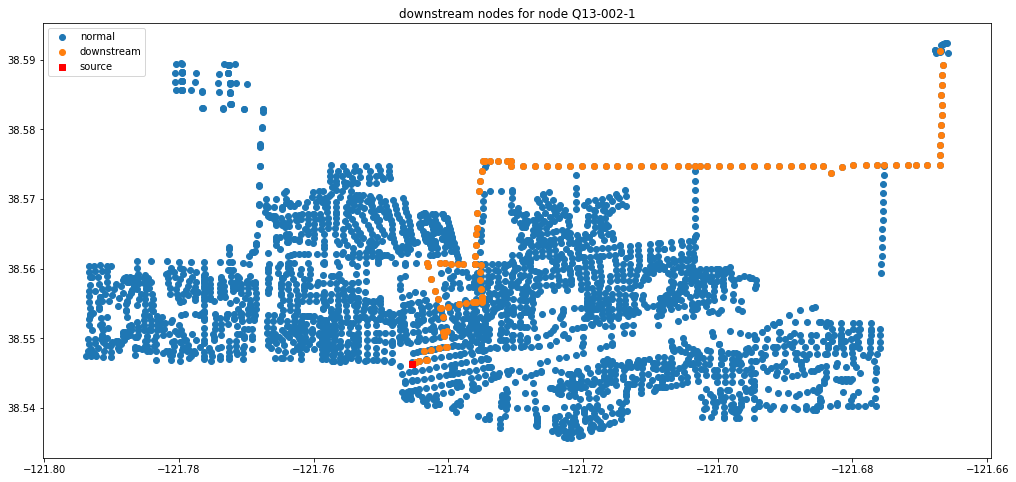

In [6]:
graph.plot_connection(graph.name_to_coor['Q13-002-1'], 'downstream')

# Composition of Waste Water Source

Here we assume that each infected person produces the same amount of waste water each day. This amount is called **a unit**. We further assume that for each census block, all manholes in that census block has the same probability of collecting the waste water produced by that infected person. 

Here we check the **expect value of units of waste water produced by infected people at each collection manhoel**.

## Example

To check how waste water produced by infected people are collected, you should call `graph.find_collection_points` method and pass a `pd.DataFrame` object as input. The dataframe should have two columns, `'census_block'` and `'positive'`, recording the number of positive cases in each census block

In [7]:
#example of an input
source = pd.DataFrame({'census_block':['061130106021000', '061130106021001', '061130106021008', '061130106021009'], 
                       'positive':[20, 10, 5, 8]})
source

,census_block,positive
0,061130106021000,20
1,061130106021001,10
2,061130106021008,5
3,061130106021009,8


In [8]:
collection_points = graph.find_collection_points(source)
collection_points.head()

,census_block,total_infection,M16-011,N10-004,N11-062,N11-072,N12-066,N13-041,N13-045,N14-031,N17-005,O12-005,O13-002,O14-008,O14-020,O14-085,O15-078,O20-001,P08-035,P08-058,P10-001,P10-015,P14-027,P14-102,P15-027,P16-041,Q14-047
0,061130101011000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,061130101011001,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,061130101011002,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,061130101011003,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,061130101011004,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
#We can see that some census blocks are not collected
values = collection_points.to_numpy()[:, 1:]
collection_points[values.sum(axis=1) > 0]

,census_block,total_infection,M16-011,N10-004,N11-062,N11-072,N12-066,N13-041,N13-045,N14-031,N17-005,O12-005,O13-002,O14-008,O14-020,O14-085,O15-078,O20-001,P08-035,P08-058,P10-001,P10-015,P14-027,P14-102,P15-027,P16-041,Q14-047
1259,061130106021000,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.272727,7.272727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1260,061130106021001,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,10.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1267,061130106021008,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1268,061130106021009,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## How many units of waste water are collected at each collection point?

Some collection points covers no population?

In [10]:
#load population data
population = pd.read_csv('./us2019_yolo.csv', dtype={'block_fips':str})
population.rename(columns={'block_fips':'census_block', 'pop2019':'positive'}, inplace=True)
population.head()

,census_block,positive
0,061130101011000,0
1,061130101011001,0
2,061130101011002,24
3,061130101011003,11
4,061130101011004,75


In [11]:
collection = graph.find_collection_points(population)
collection.drop(columns = ['census_block', 'total_infection'], inplace=True)
collection.sum(axis=0)

M16-011     1890.020417
N10-004     9156.000000
N11-062     1075.509121
N11-072     1048.948060
N12-066     1781.928462
N13-041      379.203868
N13-045    24350.641148
N14-031       17.200000
N17-005     3483.391304
O12-005     3949.122677
O13-002     5142.335787
O14-008      455.483333
O14-020       68.363636
O14-085     1404.077922
O15-078        0.000000
O20-001     5048.398727
P08-035      496.072285
P08-058      250.611111
P10-001      147.210526
P10-015      623.892544
P14-027     1029.975000
P14-102     1970.675347
P15-027        0.000000
P16-041        0.000000
Q14-047      520.812500
dtype: float64

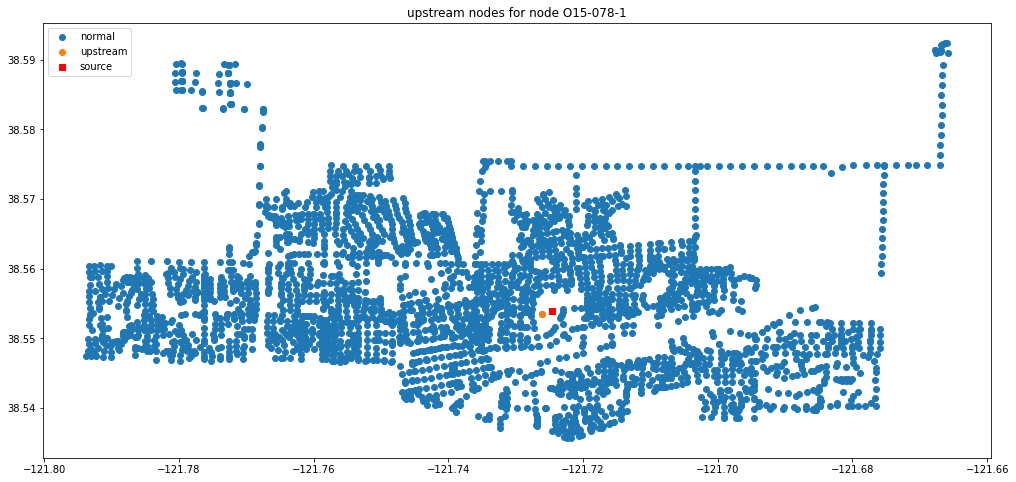

In [12]:
graph.plot_connection(graph.name_to_coor['O15-078-1'], 'upstream')

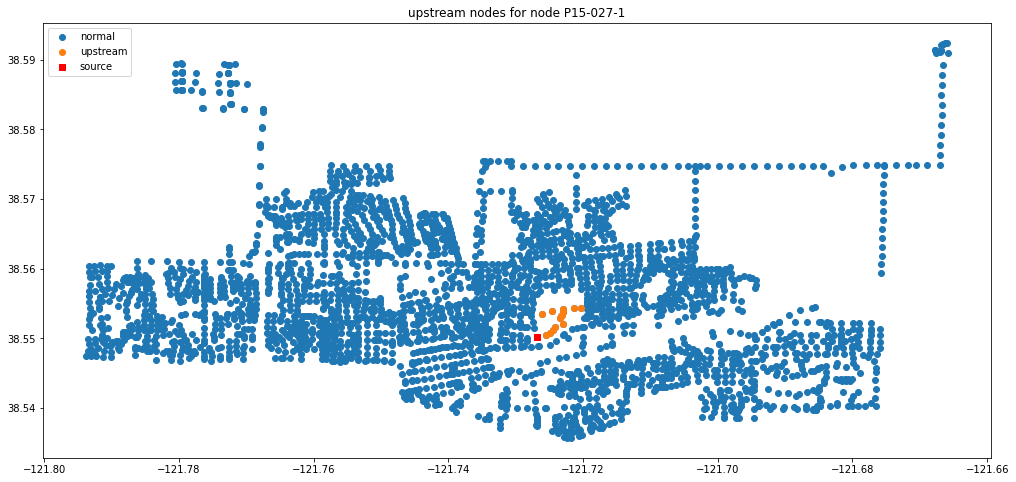

In [13]:
graph.plot_connection(graph.name_to_coor['P15-027-1'], 'upstream')

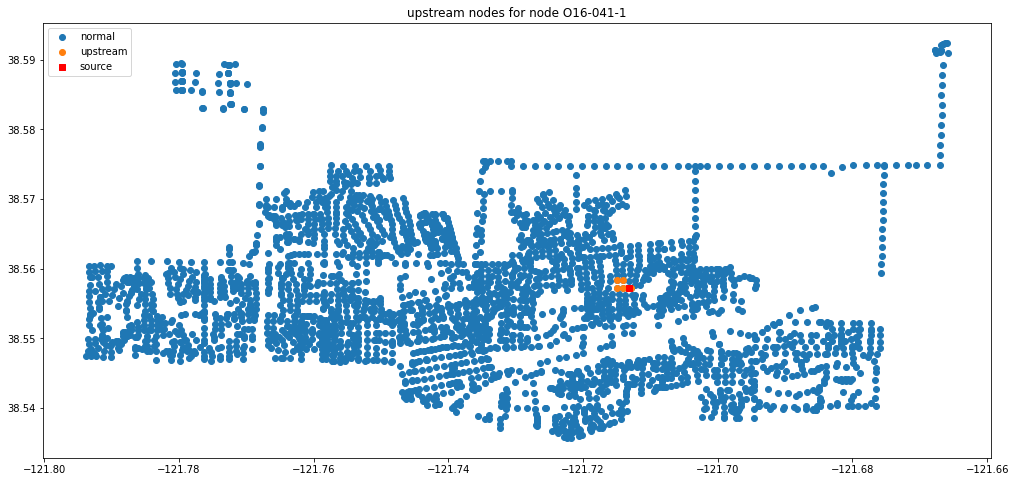

In [14]:
graph.plot_connection(graph.name_to_coor['O16-041-1'], 'upstream')

## How is waste water from each census block collected?

We divide the census blocks into four types:
  
  * All waste water collected by one collection point
  * All waste water collected, but by more than one collection points
  * Not all waste water collected
  * No waste water collected

In [15]:
population['positive'] = 1
weights = graph.find_collection_points(population)
weights.set_index('census_block', inplace=True)
weights.drop(columns = ['total_infection'], inplace=True)
values = weights.to_numpy()

In [16]:
total_collected = values.sum(axis=1)
collected_by = (values > 0).sum(axis=1)

In [17]:
#Type 1. All waste water collected by one collection point
weights[np.logical_and(total_collected == 1, collected_by == 1)]

,M16-011,N10-004,N11-062,N11-072,N12-066,N13-041,N13-045,N14-031,N17-005,O12-005,O13-002,O14-008,O14-020,O14-085,O15-078,O20-001,P08-035,P08-058,P10-001,P10-015,P14-027,P14-102,P15-027,P16-041,Q14-047
census_block,,,,,,,,,,,,,,,,,,,,,,,,,
061130104012000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
061130104012004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
061130104012005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
061130104013000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
061130104013002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
061130106083001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
061130106083002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
061130106083003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
#Type 2. All waste water collected, but by more than one collection points
weights[np.logical_and(total_collected == 1, collected_by > 1)]

,M16-011,N10-004,N11-062,N11-072,N12-066,N13-041,N13-045,N14-031,N17-005,O12-005,O13-002,O14-008,O14-020,O14-085,O15-078,O20-001,P08-035,P08-058,P10-001,P10-015,P14-027,P14-102,P15-027,P16-041,Q14-047
census_block,,,,,,,,,,,,,,,,,,,,,,,,,
061130105012000,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
061130105012017,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
061130106023002,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0,0.0
061130107011000,0.0,0.0,0.0,0.0,0.0,0.0,0.916667,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
061130107011002,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
061130107041014,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
061130107041015,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
061130107041016,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
#Type 3. Not all waste water collected
weights[np.logical_and(total_collected < 1, 0 < total_collected)]

,M16-011,N10-004,N11-062,N11-072,N12-066,N13-041,N13-045,N14-031,N17-005,O12-005,O13-002,O14-008,O14-020,O14-085,O15-078,O20-001,P08-035,P08-058,P10-001,P10-015,P14-027,P14-102,P15-027,P16-041,Q14-047
census_block,,,,,,,,,,,,,,,,,,,,,,,,,
061130104012001,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
061130104012002,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
061130104012003,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
061130104013007,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
061130105012015,0.000000,0.0,0.0,0.0,0.0,0.0,0.500000,0.0,0.000000,0.0,0.500000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
061130105052033,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
061130105052036,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.6,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
061130105052039,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.5,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
061130105053001,0.605263,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
#Type 4. No waste water collected
weights[total_collected == 0]

,M16-011,N10-004,N11-062,N11-072,N12-066,N13-041,N13-045,N14-031,N17-005,O12-005,O13-002,O14-008,O14-020,O14-085,O15-078,O20-001,P08-035,P08-058,P10-001,P10-015,P14-027,P14-102,P15-027,P16-041,Q14-047
census_block,,,,,,,,,,,,,,,,,,,,,,,,,
061130101011000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
061130101011001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
061130101011002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
061130101011003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
061130101011004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
061130115005071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
061130115005072,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
061130115005073,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
